### 공모전 소개

- 자외선 종류
  - 자외선 A(UV-A) : 파장이 가장 긴 자외선 A -> 관측 가능
  - 자외선 B(UV-B) : 파장이 다소 짧은 자외선 B, 대부분 흡수 -> 관측 가능
  - 자외선 C(UV-C) : 완전히 오존층에 흡수

- 천리안 위성 2A호 : 한반도 관측 자료 2분마다
    - 관측자료 : 가시채널 4bands + 적외채널 12bands

  - 자외선 A, B의 복사량을 지수식으로 환산한 자외선 지수(UV)제공
  - 지역(15) : 고산, 강릉, 서울, 인천, 울릉도 청주 안면도 대전 포항 대구 전주 울산 광주 부산 목포
  - Height : 15개 관측지점의 해발고도 



- 힌트
  - 총 자외선 지수는 오존량과 구름, 에어로졸,지표면 반사도,해발고도 영향
  - 따라서 기상청에서는 성층권의 이러한 오존량과 날씨의 변화를 기초로 예보

- 검증데이터 : 여름철 자외선을 산출(19.08)

### 천리안위성 2A호 데이터

> (가시채널4 + 적외채널12 총 16BANDS), 태양천정각 1종, 위성 천정각 1종, 대기외 일사량 1종, 지면 타입 1종 총 20종


- STN : 지점번호

- Lon : 경도
- Lat : 위도
- Band1 : 파랑 가시 밴드(에어로졸)
- Band2 : 초록 가시 밴드(일사량)
- Band3 : 빨강 가시 밴드(구름)
- Band4 : 식생 가시 밴드
- Band5 : 눈/얼음 채널 (적설탐지)
- Band6 : 권운 밴드 ( 권운탐지)
- Band7 : 야간 안개/ 하층운 밴드
- Band8 : 상층 수증기 밴드
- Band9 : 중층 수증기 밴드
- Band10 : 하층 수증기 밴드
- Band11 : 구름상 밴드
- Band12 : 오존 밴드
- Band13 : 대기창 밴드
- Band14 : 꺠끗한 대기창 밴드
- Band15 : 오염된 대기창 밴드
- Band16 : 이산화탄소 (C02) 밴드
- SolarZA : 태양천정각(지면에서 수직방향과 태양과 이루는 각도)
- SateZA : 위상천정각(지면에서 수직 방향과 위성과 이루는 각도
- ESR : 대기외 일사량
- LandType : 지면타입
  - 1 : 산림
  - 2 : 농지
  - 3 : 도시
  - 0,4 : 습지 또는 해안가

## 모듈

In [ ]:
!pip3 install catboost
!pip3 install autoimpute

In [ ]:
import datetime
import pickle
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/날씨')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import itertools




import pandas as pd
import pandas_profiling
import numpy as np
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid' )
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
pyo.init_notebook_mode()
#import scikitplot

from scipy import stats

#import autoimpute
#from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn.utils.fixes import loguniform
from sklearn import model_selection
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb 
import xgboost as xgb
#import catboost as cb
import statsmodels.api as sm


Output hidden; open in https://colab.research.google.com to view.

## 함수

In [ ]:
with open("/content/drive/MyDrive/날씨/data_자외선/원본(오류수정)/UV_all(0725).pkl","rb") as fr:
    data = pickle.load(fr)
data.reset_index()
df = data.copy()
df = df.reset_index().set_index('date_time')

In [ ]:
df

,stn,lon,lat,uv,band1,band2,band3,band4,band5,band6,...,band12,band13,band14,band15,band16,solarza,sateza,esr,height,landtype
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,13,126.16000,33.30000,0.0,0.00000,0.00000,0.00000,-0.00075,0.0000,-0.00065,...,250.75924,269.97608,269.70811,268.61702,259.10334,165.17963,38.96359,-9.50910,71.00,0
2020-01-01,105,128.89098,37.75147,0.0,-0.00057,0.00057,0.00030,-0.00030,0.0003,0.00000,...,246.67115,268.22810,268.41686,268.01723,256.99670,163.20549,43.95463,-9.40930,26.04,3
2020-01-01,108,126.96500,37.57100,-999.0,0.00000,0.00000,-0.00089,-0.00075,-0.0006,0.00000,...,241.24994,258.33982,258.18692,257.58363,250.50021,162.48279,43.77999,-9.37761,85.50,3
2020-01-01,112,126.62490,37.47772,0.0,-0.00057,-0.00057,-0.00060,0.00015,0.0000,-0.00065,...,241.55488,258.54927,258.64012,258.03883,251.00820,162.39995,43.67046,-9.37422,68.99,3
2020-01-01,115,130.89864,37.48129,0.0,0.00000,-0.00057,-0.00030,0.00075,0.0006,-0.00065,...,244.56708,264.88004,263.95472,262.33534,253.25397,164.19725,43.74521,-9.45200,222.80,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-25,146,127.11900,35.84080,NaN,0.00000,-0.00057,-0.00089,0.00015,0.0000,0.00000,...,258.49191,286.87485,287.19605,285.48855,271.35400,119.84431,41.81018,-4.59718,62.90,3
2022-06-25,152,129.33472,35.58250,NaN,-0.00057,0.00000,-0.00030,-0.00030,-0.0003,0.00000,...,263.99872,293.32422,293.51096,291.15861,274.60342,120.42121,41.52495,-4.67124,82.00,2
2022-06-25,156,126.89158,35.17294,NaN,0.00000,0.00000,0.00089,-0.00030,-0.0003,-0.00065,...,261.53112,290.14436,290.23278,288.05655,273.15633,120.46896,41.04849,-4.68457,72.38,3


In [ ]:
def to_datetime(df:pd.DataFrame)->pd.DataFrame:
    df_nfe = df.copy()
    if 'date_time' in df_nfe.columns:
        df_nfe['date_time'] = pd.to_datetime(df_nfe['date_time'])
        #df_nfe['DateTime'] = pd.to_datetime(df_nfe['date_time'])
        df_nfe.set_index('date_time', inplace=True)
    return df_nfe

x_list = ['uv', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10', 'band11', 'band12', 'band13', 'band14', 'band15', 'band16']
def del_999(df)->pd.DataFrame:
  df_del999 = df.copy()
  for col in x_list:
    df_del999[col] = df_del999[col].replace(-999,np.nan)
  return df_del999

def train_test_split(df:pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
  train = df.loc[df.index<'2022-01-01 00:00:00']
  test = df.loc[df.index>'2022-01-01 00:00:00']
  return (train, test)


def  stn_split(df:pd.DataFrame,spn_num :int)->pd.DataFrame:
  if 'stn' in df.columns:
    df_stn_num = df.loc[df['stn']==spn_num,:]
    df_stn_num = df_stn_num.drop(['lon','lat','landtype','sateza','height','stn'],axis=1)
    return df_stn_num  

def lag_feature(df:pd.DataFrame,shift_num:int):
  df_lag =df.copy()
  df_lag['uv_lag'+f'{shift_num}'] = df_lag['uv'].shift(shift_num)
  return df_lag
  
def time_feature(df:pd.DataFrame,col:str): #day_max_val = 365
    df_time_feature = df.copy()
    #df_time_feature ['minute']=df_time_feature.index.minute
    #df_time_feature ['hour']=df_time_feature.index.hour
    #df_time_feature ['day']=df_time_feature.index.day
    #df_time_feature ['month']=df_time_feature.index.month
    #df_time_feature[col + '_sin'] = np.sin(2 * np.pi * df_time_feature[col]/max_val)
    #df_time_feature[col + '_cos'] = np.cos(2 * np.pi * df_time_feature[col]/max_val)
    #if col+'_sin' not in df.columns:
    #  concat_df = pd.concat([df,df_time_feature[[col + '_sin']],df_time_feature[[col + '_cos']]],axis=1)
    
    timestamp_s = df_time_feature.index.map(datetime.datetime.timestamp)
    day = 24*60*60
    month  = (30.436875) * day
    year = (365.2425) * day
    if col == 'Day':
      df_time_feature['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
      df_time_feature['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
      return df_time_feature
    if col == '2/Day':
      df_time_feature['2/Day sin'] = np.sin(timestamp_s * (2 * np.pi / day*2))
      df_time_feature['2/Day cos'] = np.cos(timestamp_s * (2 * np.pi / day*2))
    if col == '3/Day':
      df_time_feature['3/Day sin'] = np.sin(timestamp_s * (2 * np.pi / day*3))
      df_time_feature['3/Day cos'] = np.cos(timestamp_s * (2 * np.pi / day*3))
      return df_time_feature
    if col == 'Month':
      df_time_feature['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
      df_time_feature['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
      return df_time_feature    
    if col == 'Year':
      df_time_feature['year'] = df_time_feature.index.year
      df_time_feature['year'] = df_time_feature['year'].replace(2020,0)
      df_time_feature['year'] = df_time_featuret_df['year'].replace(2021,1)
      return df_time_feature
    return df_time_feature


def pps(df:pd.DataFrame,df_test,scaler:str):
  standard_scaler = preprocessing.StandardScaler()
  robust_scaler = preprocessing.RobustScaler()
  minmax_scaler = preprocessing.MinMaxScaler()
  normalize_scaler = preprocessing.Normalizer()
  not_uv=[]
  for column in df.columns:
    if column != 'uv':
      not_uv.append(column)
  if scaler == 'standard':
    standard_df = pd.DataFrame(standard_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    standard_df = pd.concat([df[['uv']],standard_df],axis=1)
    return standard_df
  if scaler == 'robust':
    robust_df = pd.DataFrame(robust_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    robust_df = pd.concat([df[['uv']],robust_df],axis=1)
    return robust_df
  if scaler == 'minmax':
    minmax_df = pd.DataFrame(minmax_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    minmax_df = pd.concat([df[['uv']],minmax_df],axis=1)
    minmax_test_df = pd.DataFrame(minmax_scaler.transform(df_test[not_uv]),index=df_test.index, columns = not_uv)
    minmax_test_df = pd.concat([df_test[['uv']],minmax_test_df],axis=1)
    return minmax_df,minmax_test_df
  if scaler == 'normalize':
    normalize_df = pd.DataFrame(normalize_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    normalize_df = pd.concat([df[['uv']],normalize_df],axis=1)
    return normalize_df
  if scaler == 'power':
    power_df = pd.DataFrame(power_scaler.fit_transform(df[not_uv]),index=df.index, columns = not_uv)
    power_df = pd.concat([df[['uv']],power_df],axis=1)
    return power_df          





In [ ]:
import statsmodels.api as sm


In [ ]:
df = to_datetime(df)
df = del_999(df)
train_set,test = train_test_split(df)
train_108 = stn_split(train_set,108)

In [ ]:

train_108 = train_108.asfreq('10T')

## 모델(pycaret을 통해 모델 선정)

In [ ]:
lgbr = lgb.LGBMRegressor(n_jobs=-1,randoms_state=42)
cbr = cb.CatBoostRegressor(random_state=42)
ef = ensemble.ExtraTreesRegressor(n_jobs=-1,random_state=42)
#rf = ensemble.RandomForestRegressor(n_jobs=-1,random_state=42)
xbgr = xgb.XGBRegressor(random_state=42)
knn = KNeighborsRegressor(n_jobs=-1)
models = [
          lgbr,
          cbr,
          ef,
#          rf,
          xbgr,
          knn]

## CV

In [ ]:
kfcv = model_selection.KFold(10,shuffle=True,random_state=42)

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits 
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X) #
        k_fold_size = n_samples // self.n_splits 
        indices = np.arange(n_samples) 
    
        margin = 0
        for i in range(self.n_splits): 
            start = i * k_fold_size 
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    plt.xticks([10000,20000,30000,40000,50000,60000,70000], labels = [str(standard_df.iloc[[10000]].index.date).split('(')[1].split(')')[0],
                                                                      str(standard_df.iloc[[20000]].index.date).split('(')[1].split(')')[0],
                                                                      str(standard_df.iloc[[30000]].index.date).split('(')[1].split(')')[0],
                                                                      str(standard_df.iloc[[40000]].index.date).split('(')[1].split(')')[0],
                                                                      str(standard_df.iloc[[50000]].index.date).split('(')[1].split(')')[0],
                                                                      str(standard_df.iloc[[60000]].index.date).split('(')[1].split(')')[0],
                                                                      str(standard_df.iloc[[70000]].index.date).split('(')[1].split(')')[0]])
    plt.xticks(rotation = 90)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

## 요약 변수 생성

### 주기

In [ ]:
#Year 후진선택
train_108_month = time_feature(train_108,'month',12)
train_108_month.drop('year',inplace=True,axis=1)
train_108_month.dropna(inplace=True)
train_108_Nmonth = train_108.dropna()

lgbr = lgb.LGBMRegressor()
cbr = cb.CatBoostRegressor()
ef = ensemble.ExtraTreesRegressor(n_jobs=-1)
rf = ensemble.RandomForestRegressor(n_jobs=-1)
knn = KNeighborsRegressor(n_jobs=-1)
models = [lgbr,cbr,ef,rf, knn]
result = {'df':[],'model':[],'score':[]}
search_df_list = [train_108_month,train_108_Nmonth]

for search_df in tqdm(search_df_list):
  search_df = pps(search_df,'minmax')
  for model in tqdm(models):
    scores = model_selection.cross_val_score(model,X=search_df.iloc[:,1:],y=search_df['uv'],cv=kfcv,n_jobs=-1,scoring='neg_mean_squared_error')
    score = np.mean(scores)
    result['df'].append(f'{search_df}')
    result['model'].append(model)
    result['score'].append(score)

result = pd.DataFrame(result)
result.to_csv('month.csv')

In [ ]:

# month 후진선택
train_108_year = time_feature(train_108,'month',12)
train_108_year.drop(['month_sin','month_cos'],inplace=True,axis=1)
train_108_year.dropna(inplace=True)
train_108_Nf = train_108.dropna()


result = {'df':[],'model':[],'score':[]}
search_df_list = [train_108_year,train_108_Nf]

for i,search_df in tqdm(enumerate(search_df_list),desc='search_df'):
  search_df = pps(search_df,'minmax')
  for model in tqdm(models,desc='model_fit'):
    scores = model_selection.cross_val_score(model,X=search_df.iloc[:,1:],y=search_df['uv'],cv=kfcv,n_jobs=-1,scoring='neg_mean_squared_error')
    score = np.mean(scores)
    if i ==0:
      result['df'].append('O')
    else: result['df'].append('X')
    result['model'].append(model)
    result['score'].append(score)

result = pd.DataFrame(result)
#result.to_csv('month.csv')

In [ ]:

# hour 후진 선택
train_108_date = time_feature(train_108,'hour',23)
train_108_date.drop(['year'],inplace=True,axis=1)
train_108_date.dropna(inplace=True)
train_108_Nf = train_108.dropna()

result = {'df':[],'model':[],'score':[]}
search_df_list = [train_108_date,train_108_Nf]

for i,search_df in tqdm(enumerate(search_df_list),desc='search_df'):
  search_df = pps(search_df,'minmax')
  for model in tqdm(models,desc='model_fit'):
    scores = model_selection.cross_val_score(model,X=search_df.iloc[:,1:],y=search_df['uv'],cv=kfcv,n_jobs=-1,scoring='neg_mean_squared_error')
    score = np.mean(scores)
    if i ==0:
      result['df'].append('O')
    else: result['df'].append('X')
    result['model'].append(model)
    result['score'].append(score)

result = pd.DataFrame(result)
#result.to_csv('month.csv')

search_df: 0it [00:00, ?it/s]
model_fit: 100%|██████████| 4/4 [06:57<00:00, 104.44s/it]
search_df: 1it [06:57, 417.81s/it]
model_fit: 100%|██████████| 4/4 [06:32<00:00, 98.14s/it] 
search_df: 2it [13:30, 405.20s/it]


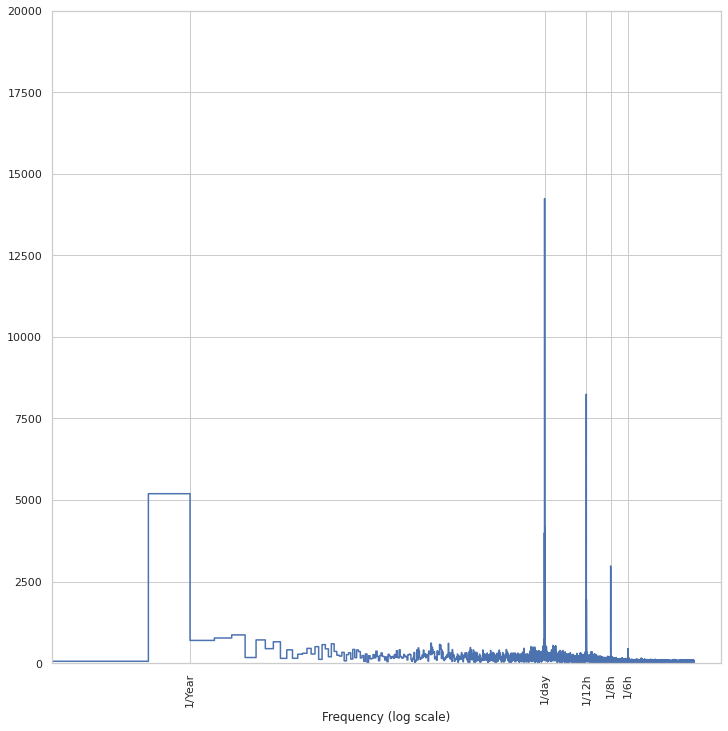

In [ ]:
df_1h = df[::6]
df_1h = df_1h.set_index(['date_time'])
plt.figure(figsize=(12,12))
fft = tf.signal.rfft(df_1h['uv'])
f_per_dataset = np.arange(0, len(fft)) 

n_samples_h = len(df_1h['uv'])
hours_per_year = 24*365.2524 
years_per_dataset = n_samples_h/(hours_per_year) 
f_per_year = f_per_dataset/years_per_dataset 

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524,365.2524*2,365.2524*3,365.2524*4], labels=['1/Year', '1/day','1/12h','1/8h','1/6h'],rotation=90)
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
timestamp_s = train_108.index.map(datetime.datetime.timestamp)
day = 24*60*60 # 86400초
month = (30.436875)*day
year = (365.2425)*day
day_sin = np.sin(timestamp_s * (2 * np.pi / day))
day_cos = np.cos(timestamp_s * (2 * np.pi / day))
day2_sin = np.sin(timestamp_s * (2 * np.pi / day*2))
day2_cos = np.cos(timestamp_s * (2 * np.pi / day*2))
day3_sin = np.sin(timestamp_s * (2 * np.pi / day*3))
day3_cos = np.cos(timestamp_s * (2 * np.pi / day*3))
train_108_day = train_108.copy()
train_108_day2 = train_108.copy()
train_108_day3 = train_108.copy()
train_108_day['day_sin'] = day_sin
train_108_day['day_cos'] = day_cos
train_108_day2['day_sin'] = day2_sin
train_108_day2['day_cos'] = day2_cos
train_108_day3['day_sin'] = day3_sin
train_108_day3['day_cos'] = day3_cos

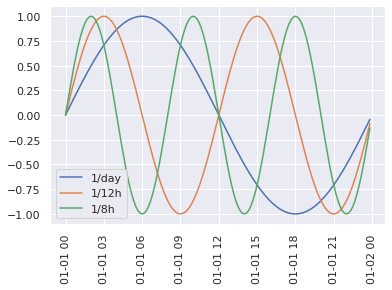

In [ ]:
%matplotlib inline 
plt.plot(train_108_day['day_sin'][:6*24])
plt.plot(train_108_day2['day_sin'][:6*24])
plt.plot(train_108_day3['day_sin'][:6*24])
plt.xticks(rotation=90)
plt.legend(['1/day','1/12h','1/8h'])

In [ ]:

result = {'df':[],'model':[],'score':[]}
search_df_list = [train_108_day,train_108_day2,train_108_day3,]

for i,search_df in tqdm(enumerate(search_df_list),desc='search_df'):
  search_df = pps(search_df,'minmax')
  search_df.dropna(inplace=True)
  for model in tqdm(models,desc='model_fit'):
    scores = model_selection.cross_val_score(model,X=search_df.iloc[:,1:],y=search_df['uv'],cv=kfcv,n_jobs=-1,scoring='neg_mean_squared_error')
    score = np.mean(scores)
    if i ==0:
      result['df'].append('1/day')
    elif i == 1: 
      result['df'].append('2/day')
    else: result['df'].append('3/day')
    result['model'].append(model)
    result['score'].append(score)

result = pd.DataFrame(result)
#result.to_csv('month.csv')


search_df: 0it [00:00, ?it/s]
model_fit: 100%|██████████| 4/4 [09:09<00:00, 137.43s/it]
search_df: 1it [09:09, 549.95s/it]
model_fit: 100%|██████████| 4/4 [09:03<00:00, 135.82s/it]
search_df: 2it [18:13, 546.14s/it]
model_fit: 100%|██████████| 4/4 [08:49<00:00, 132.40s/it]
search_df: 3it [27:03, 541.05s/it]


In [ ]:
result.groupby('df')['score'].mean().reset_index()

,df,score
0,1/day,-0.108455
1,2/day,-0.108305
2,3/day,-0.109098


### lag

<Figure size 864x432 with 0 Axes>

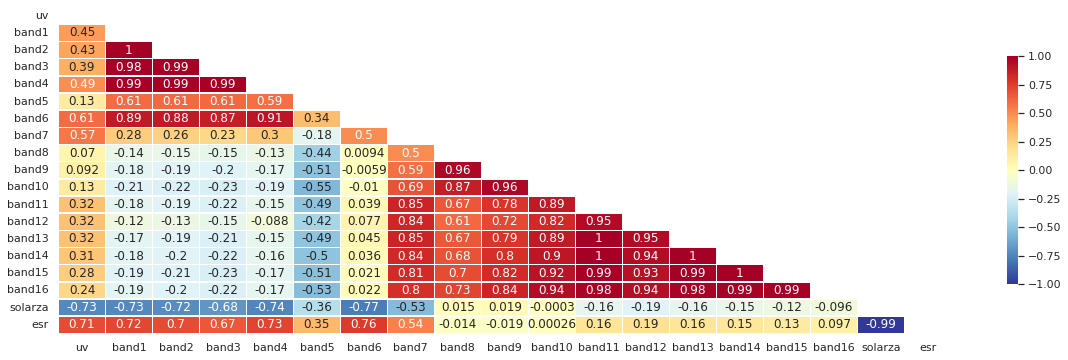

In [ ]:
train_108 = pps(trai_108,'minmax)
import numpy as np
train_108_corr = train_108.corr()
plt.figure(figsize=(12, 6))

#마스크 설정
mask=np.zeros_like(train_108_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20, 6))
sns.heatmap(train_108_corr,
            cmap='RdYlBu_r',
            annot=True, #실제값 표시
            mask=mask,
            linewidths=.5, #경계면 실선으로 구분
            cbar_kws={'shrink':.7}, #컬러바 크기 줄이기
            vmin=-1,vmax=1 #컬러바 범위설정
            )

Text(0.5, 1.0, '8/15')

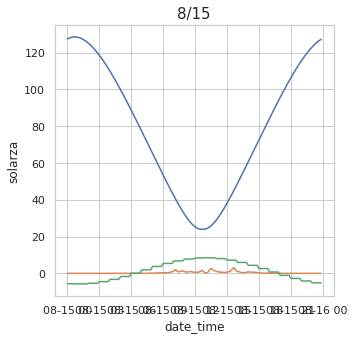

In [ ]:
sns_data = train_108['2020-08-15 00:00:00' : '2020-08-15 23:50:00']
plt.figure(figsize=(5,5))
sns.lineplot(data=sns_data,x=sns_data.index,y='solarza')
sns.lineplot(data=sns_data,x=sns_data.index,y='uv')
sns.lineplot(data=sns_data,x=sns_data.index,y='esr')
plt.title('8/15',fontsize=15)

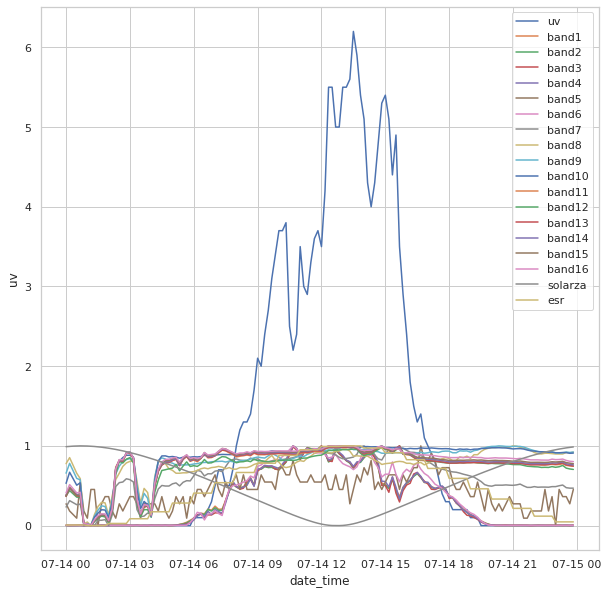

In [ ]:
sns_data = pps(train_108['2020-07-14 00:00:00' : '2020-07-14 23:50:00'],'minmax') #비,소나기 박무
plt.figure(figsize=(10,10))
for column in col_list:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(col_list)
#plt.legend(['uv','band8','band13'])
#plt.title('8/15',fontsize=15)

1. band 1, 2,3 ,4,6 래그 10~20분 정도? ,band6만따로
2. band 5 
3. band 7 
4. band 8 9 10 (서로좀다름)  #수증기라 이동?
5. band 11 12 13 15 16

In [ ]:
train_108.describe().T

,count,mean,std,min,25%,50%,75%,max
uv,91437.0,0.990482,1.722039,0.00000,0.000000,0.000000,1.30000,10.20000
band1,104060.0,0.100459,0.153840,-0.01133,0.000000,0.010200,0.14672,1.14828
band2,104060.0,0.096603,0.152845,-0.01141,0.000000,0.008550,0.13515,1.15594
band3,104060.0,0.090111,0.153048,-0.01192,0.000000,0.005660,0.11414,1.04187
band4,104060.0,0.109082,0.170554,-0.01197,0.000000,0.006580,0.16429,1.11981
band5,104060.0,0.011082,0.035177,-0.01208,0.000000,0.000300,0.00272,0.51774
band6,104060.0,0.071190,0.104801,-0.01290,0.000000,0.002580,0.12448,0.65208
band7,104060.0,279.639109,16.707705,203.99058,268.334360,280.245340,292.00171,318.93773
band8,104060.0,236.503036,5.826319,204.98210,232.980800,236.795700,240.35547,258.18742
band9,104060.0,244.695915,7.352453,204.28915,241.035800,245.666150,249.54366,264.63748


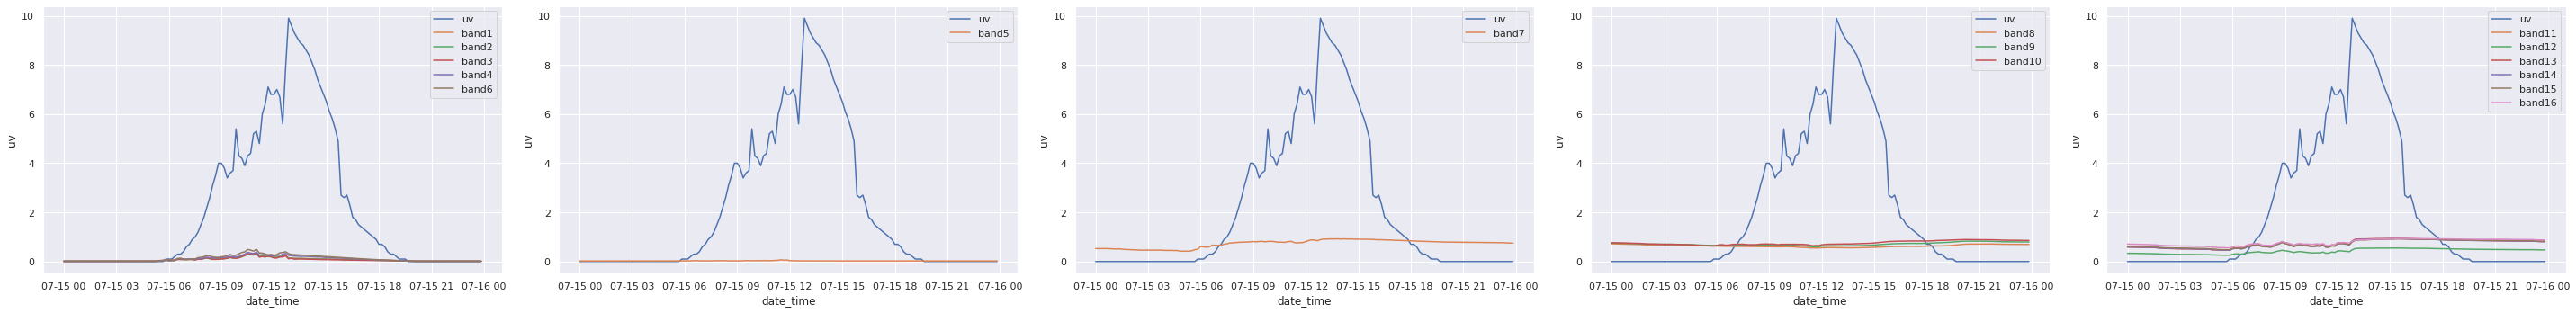

In [ ]:
train_108 = pps(train_108,'minmax')
sns_data = train_108['2020-07-15 00:00:00' : '2020-07-15 23:50:00']
plt.figure(figsize=(40,5))
plt.subplot(1,5,1)
for column in ['uv','band1','band2','band3','band4','band6']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band1','band2','band3','band4','band6'])
plt.subplot(1,5,2)
for column in ['uv','band5']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band5'])
plt.subplot(1,5,3)
for column in ['uv','band7']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band7'])
plt.subplot(1,5,4)
for column in ['uv','band8','band9','band10']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band8','band9','band10'])
plt.subplot(1,5,5)
for column in ['uv','band11','band12','band13','band14','band15','band16']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band11','band12','band13','band14','band15','band16'])

plt.tight_layout()

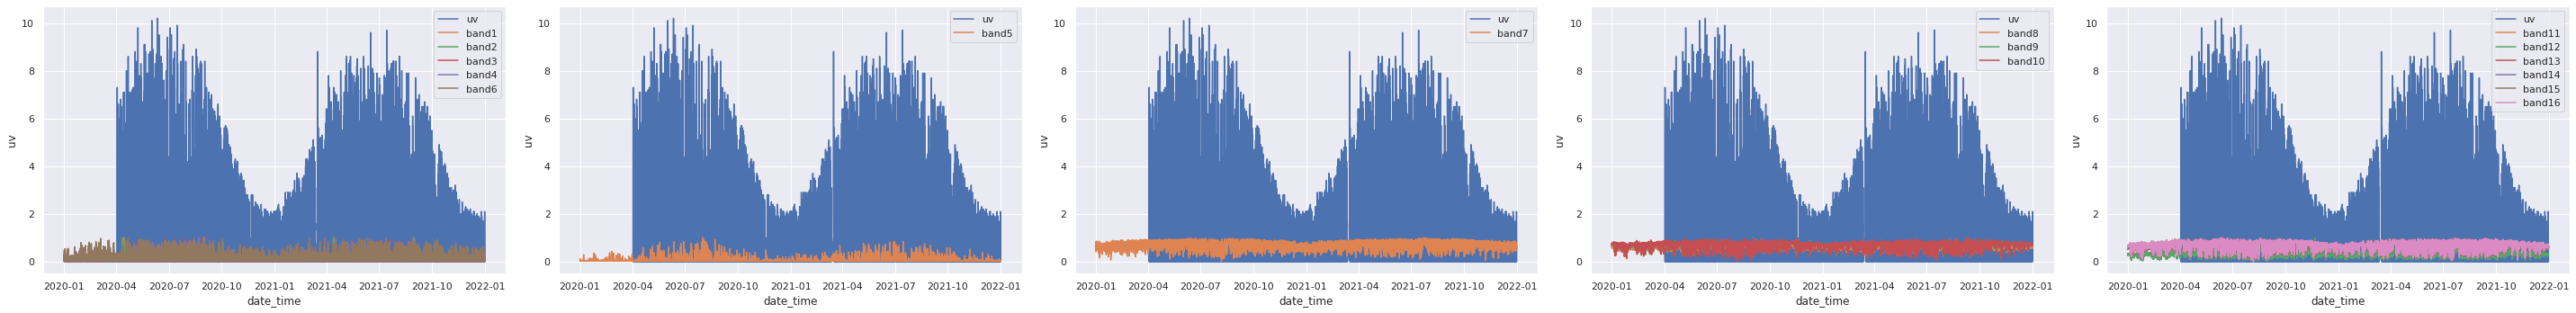

In [ ]:
train_108 = pps(train_108,'minmax')
sns_data = train_108
plt.figure(figsize=(40,5))
plt.subplot(1,5,1)
for column in ['uv','band1','band2','band3','band4','band6']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band1','band2','band3','band4','band6'])
plt.subplot(1,5,2)
for column in ['uv','band5']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band5'])
plt.subplot(1,5,3)
for column in ['uv','band7']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band7'])
plt.subplot(1,5,4)
for column in ['uv','band8','band9','band10']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band8','band9','band10'])
plt.subplot(1,5,5)
for column in ['uv','band11','band12','band13','band14','band15','band16']:
  sns.lineplot(data=sns_data,x=sns_data.index,y=column)
plt.legend(['uv','band11','band12','band13','band14','band15','band16'])

plt.tight_layout()

In [ ]:
train_108_shift9 = train_108.copy()
train_108_shift9.loc[:,['band8','band9','band10']] = train_108[['band8','band9','band10']].shift(-9)
train_108_shift12 = train_108.copy()
train_108_shift12.loc[:,['band8','band9','band10']] = train_108[['band8','band9','band10']].shift(-12)
train_108_shift15 = train_108.copy()
train_108_shift15.loc[:,['band8','band9','band10']] = train_108[['band8','band9','band10']].shift(-15)
train_108_shift20 = train_108.copy()
train_108_shift20.loc[:,['band8','band9','band10']] = train_108[['band8','band9','band10']].shift(-20)

In [ ]:
#result = {'shift_num' : [] , 'model': [], 'score': []}
search_shift_df = [train_108_shift9, train_108_shift12, train_108_shift15 , train_108_shift20 ]
for i,shift_df in tqdm(enumerate(search_shift_df),desc='search df'):
  shift_dropna_df = shift_df.dropna()
  for model in tqdm(models,desc='model fit'):
    scores = model_selection.cross_val_score(model,shift_dropna_df.iloc[:,1:],shift_dropna_df['uv'],scoring='neg_root_mean_squared_error',cv=kfcv,n_jobs=-1,)
    score = -np.mean(scores)
    result['shift_num'].append(f'Shift_{i+20}')
    result['model'].append(f'{model}')
    result['score'].append(score)

search df: 0it [00:00, ?it/s]
model fit: 100%|██████████| 5/5 [04:44<00:00, 56.87s/it]
search df: 1it [04:44, 284.39s/it]
model fit: 100%|██████████| 5/5 [04:31<00:00, 54.36s/it]
search df: 2it [09:16, 277.01s/it]
model fit: 100%|██████████| 5/5 [04:39<00:00, 55.96s/it]
search df: 3it [13:56, 278.30s/it]
model fit: 100%|██████████| 5/5 [04:33<00:00, 54.68s/it]
search df: 4it [18:29, 277.37s/it]


In [ ]:
shift_result = pd.DataFrame(result)
shift_result.groupby('shift_num')['score'].mean()

shift_num
Shift_0     0.358631
Shift_1     0.361507
Shift_2     0.361611
Shift_20    0.360766
Shift_21    0.361416
Shift_22    0.361206
Shift_23    0.362259
Shift_3     0.361598
Shift_4     0.361271
Shift_5     0.361313
Shift_6     0.361080
Shift_7     0.361519
Shift_8     0.359901
Name: score, dtype: float64

## 스케일링

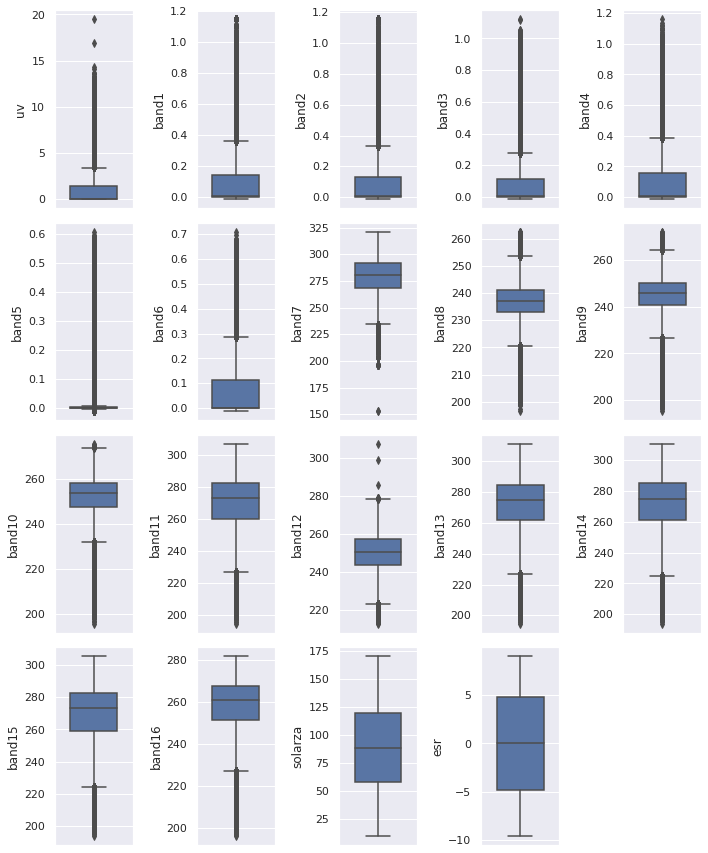

In [ ]:
#stn_all
ax = []
fig = plt.figure(figsize= (10,12))
for i in range(1,len(train_108.columns)+1):
  ax.append(fig.add_subplot(4,5,i))

for i,columns in enumerate(train_108.columns):
  sns.boxplot(y=columns,
          width= 0.6,
          data=train_set,
          ax=ax[i]
          )

plt.tight_layout()

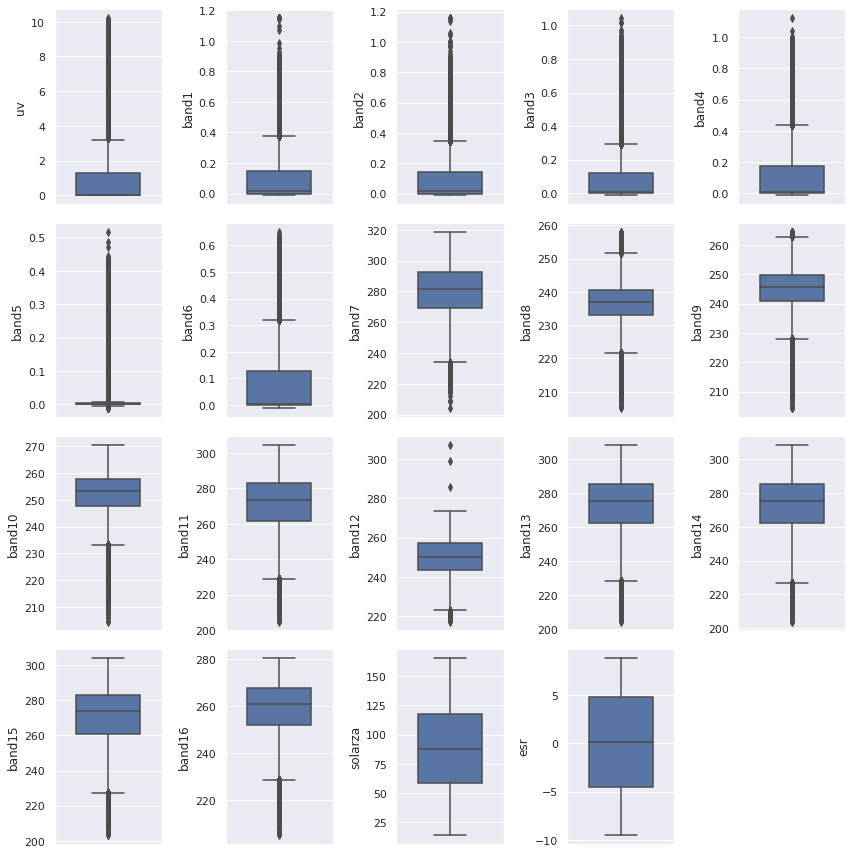

In [ ]:
#stn==108
ax = []
fig = plt.figure(figsize= (12,12))
for i in range(1,len(train_108.columns)+1):
  ax.append(fig.add_subplot(4,5,i))

for i,columns in enumerate(train_108.columns):
  sns.boxplot(y=columns,
          width= 0.6,
          data=train_108,
          ax=ax[i]
          )

plt.tight_layout()

In [ ]:
train_108.dropna(inplace=True)
train_108 = train_108.reset_index()
train_108.drop('date_time',inplace=True,axis=1)

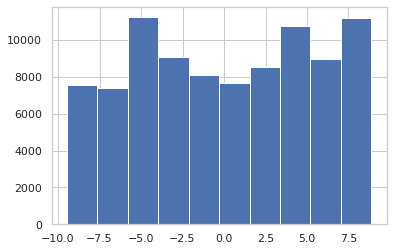

In [ ]:
train_108['esr'].hist()

In [ ]:
search_scaler_df = train_set.drop(['stn'],axis=1)
search_scaler_df.dropna(inplace=True)
lgbr = lgb.LGBMRegressor(learn_rate=0.005611516415334503, max_depth=8, min_child_samples=5,
              n_estimators=152, num_leaves=92, random_state=42,
              subsample=0.6314377764193271, subsample_freq=3,n_jobs=-1)
cbr = cb.CatBoostRegressor(random_state=42)
ef = ensemble.ExtraTreesRegressor(random_state=42)
rf = ensemble.RandomForestRegressor(random_state=42,n_jobs=-1)
#knn = KNeighborsRegressor(n_jobs=-1)
models = [
          #lgbr,
          #cbr,
          ef,
          #rf
        ]
result = {'scaler':[],'model':[],'score':[]}
scaler_list = [
               'power',
#              'standard',
#               'robust',
#               'minmax',
               'normalize'
]

for scaler in tqdm(scaler_list,desc='scaler_fit'):
  train_spn_scaler = pps(search_scaler_df,scaler)
  for model in tqdm(models,desc='model_fit'):
    scores = model_selection.cross_val_score(model,X=train_spn_scaler.iloc[:,1:],y=train_spn_scaler['uv'],cv=kfcv,scoring='neg_mean_squared_error')
    score = np.mean(scores)
    result['scaler'].append(scaler)
    result['model'].append(f'{model}')
    result['score'].append(score)'''

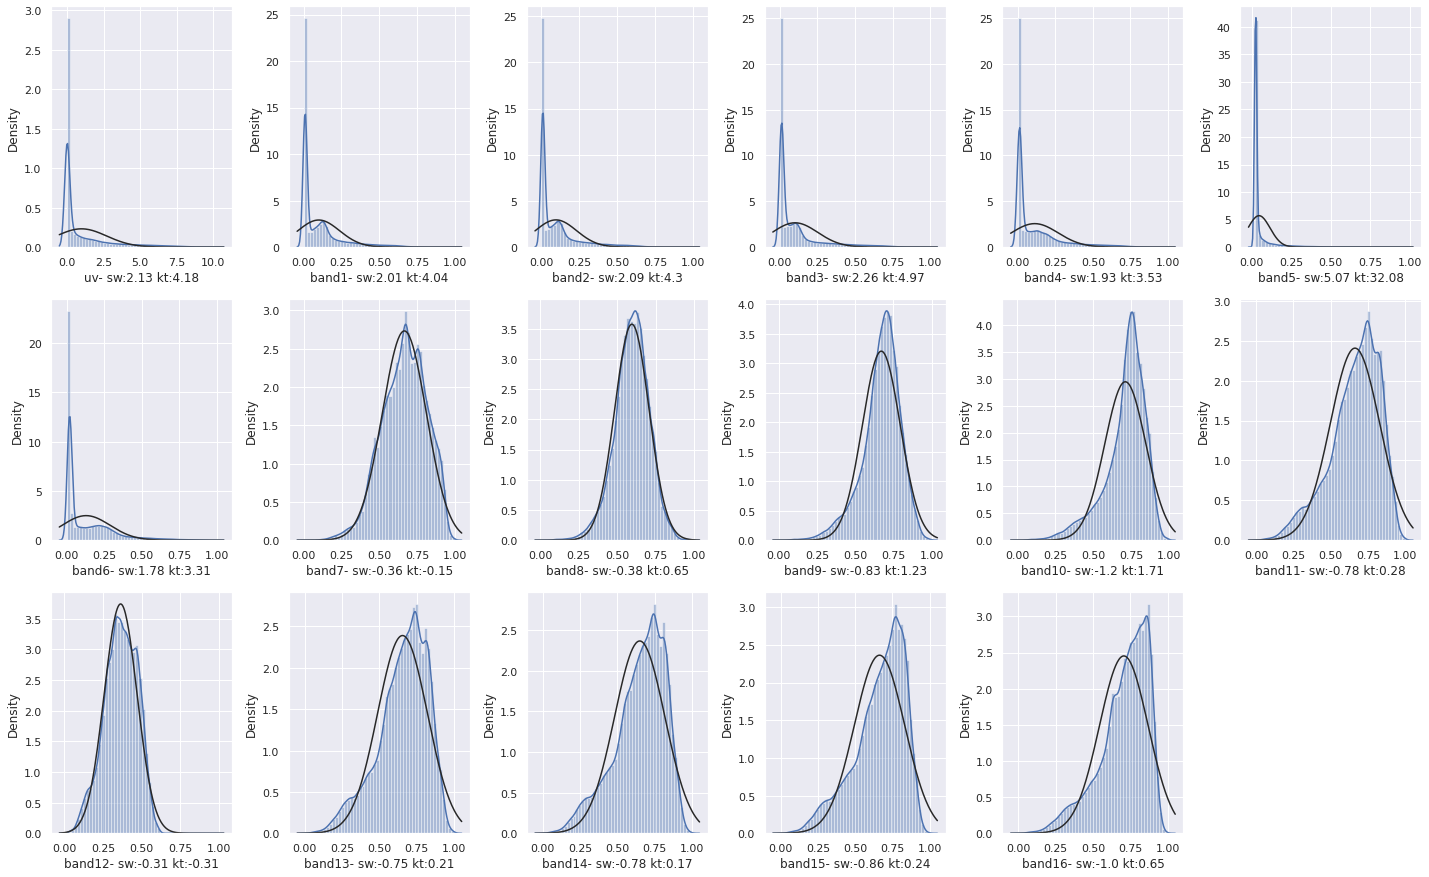

In [ ]:
fig = plt.figure(figsize= (20,20))
ax = []
for i in range(1,len(x_list)+1):
  ax.append(fig.add_subplot(5,len(x_list)//5+3,i))

for i,x in enumerate(x_list):
  x_skew = train_108[x].skew()
  x_kurt = train_108[x].kurt()
  sns.distplot(train_108[x],norm_hist=True, ax=ax[i], fit=stats.norm,
               axlabel=f'{x}- sw:{round(x_skew,2)} kt:{round(x_kurt,2)}')

plt.tight_layout()

In [ ]:
train_108 = pd.concat([train_108.loc[:,(train_108.skew()>1)],train_108.loc[:,(train_108.skew()<-1)]],axis=1)
power_scaler = preprocessing.PowerTransformer(standardize=False)
train_108_power = pd.DataFrame(power_scaler.fit_transform(train_108),columns = train_108.columns)
minmax_scaler = preprocessing.MinMaxScaler()
train_108_power_minmax = pd.DataFrame(minmax_scaler.fit_transform(train_108_power),columns = train_108_power.columns)
scale_list = train_108_power_minmax.columns

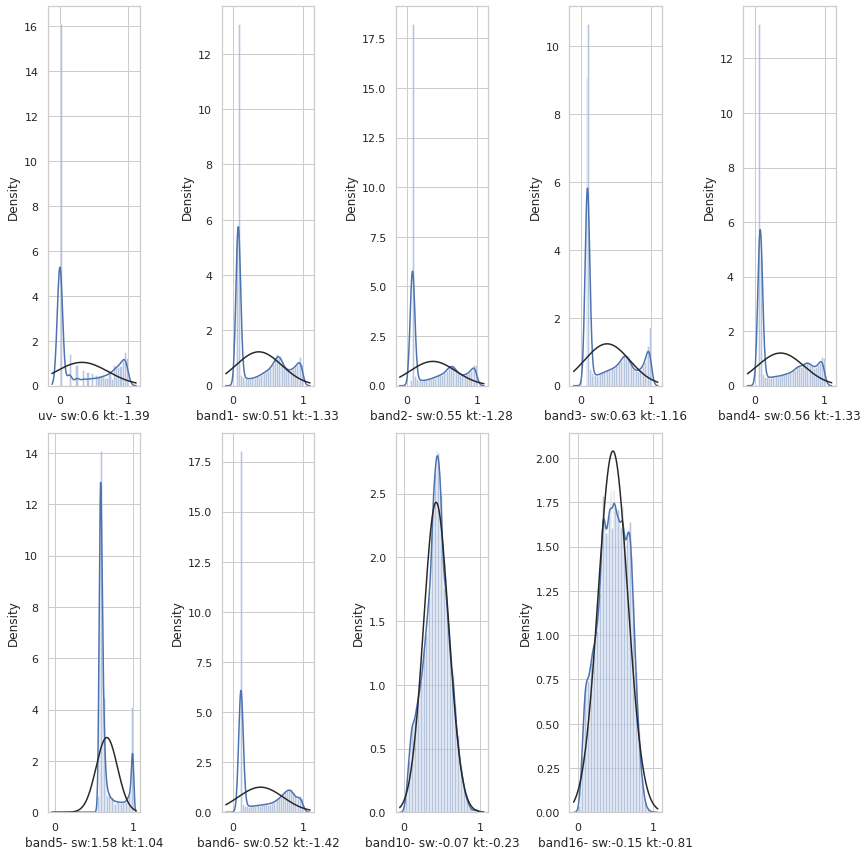

In [ ]:
fig = plt.figure(figsize= (12,12))
ax = []
for i in range(1,len(scale_list)+1):
  ax.append(fig.add_subplot(2,5,i))

for i,x in enumerate(scale_list):
  x_skew = train_108_power_minmax[x].skew()
  x_kurt = train_108_power_minmax[x].kurt()
  sns.distplot(train_108_power_minmax[x],norm_hist=True, ax=ax[i], fit=stats.norm,
               axlabel=f'{x}- sw:{round(x_skew,2)} kt:{round(x_kurt,2)}')

plt.tight_layout()

In [ ]:
search_scaler_df = train_set.drop(['stn'],axis=1)
search_scaler_df.dropna(inplace=True)
minmax_df =pps(search_scaler_df,'minmax')
power_scaler = preprocessing.PowerTransformer(standardize=False)
power_df = pd.DataFrame(power_scaler.fit_transform(search_scaler_df[['band1','band2','band3','band4','band5','band6','band10','band16']]),
                        columns = ['band1','band2','band3','band4','band5','band6','band10','band16'])
minmax_power_df = search_scaler_df.copy()
for col in ['band1','band2','band3','band4','band5','band6','band10','band16']:
  minmax_power_df[col] = np.array(power_df[col])
minmax_power_df = pps(minmax_power_df,'minmax')  
models = [
          lgbr,
          cbr,
          ef,
          xbgr,
          knn
          ]
#result = {'scaler':[],'model':[],'score':[]}
scaler_list = [
               search_scaler_df,
               minmax_df,
               minmax_power_df,
                ]

for i,scaler_df in tqdm(enumerate(scaler_list),desc='scaler_fit'): 
  for model in tqdm(models,desc='model_fit'):
    scores = model_selection.cross_val_score(model,X=scaler_df.iloc[:,1:],y=scaler_df['uv'],cv=kfcv,scoring='neg_root_mean_squared_error')
    score = np.mean(scores)   
    result['scaler'].append('minmax')
    elif i==1:
      result['scaler'].append('minmax')
    else:
      result['scaler'].append('power_minmax')
    result['model'].append(f'{model}')
    result['score'].append(score)



In [ ]:
train_108.isna().sum()

uv           0
band1        0
band2        0
band3        0
band4        0
band5        0
band6        0
band7        0
band8        0
band9        0
band10       0
band11       0
band12       0
band13       0
band14       0
band15       0
band16       0
solarza      0
esr          0
Month sin    0
Month cos    0
Day sin      0
Day cos      0
2/Day sin    0
2/Day cos    0
3/Day sin    0
3/Day cos    0
dtype: int64

## 결측치 처리

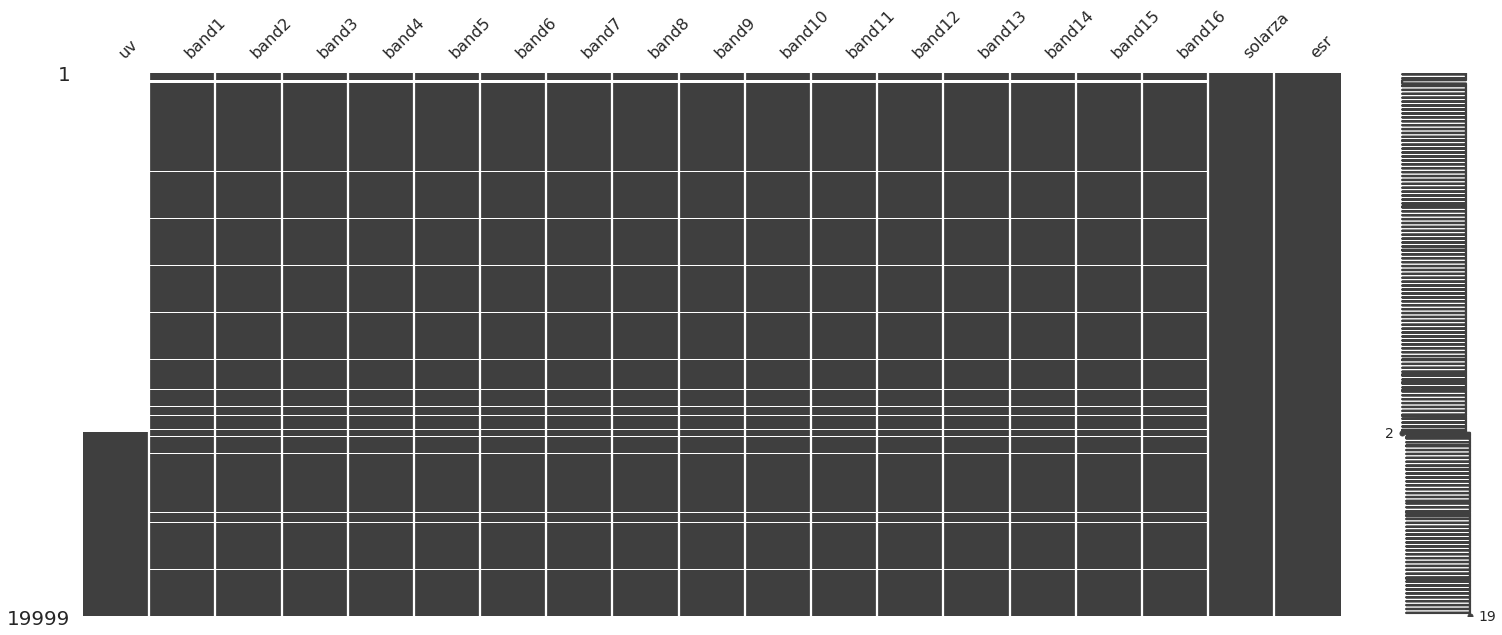

In [ ]:
from autoimpute import visuals
%matplotlib inline 

autoimpute.visuals.plot_md_locations(train_108[1:20000])

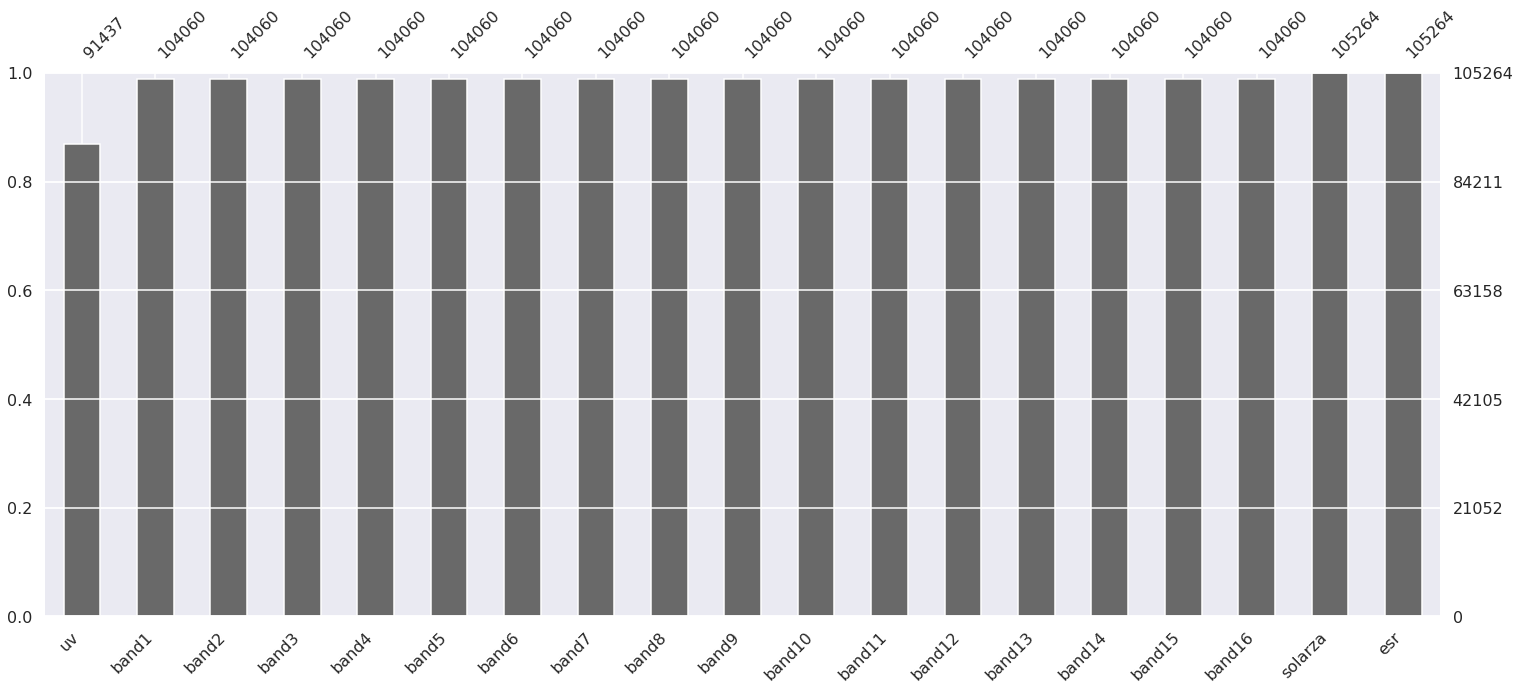

In [ ]:
autoimpute.visuals.plot_md_percent(train_108)

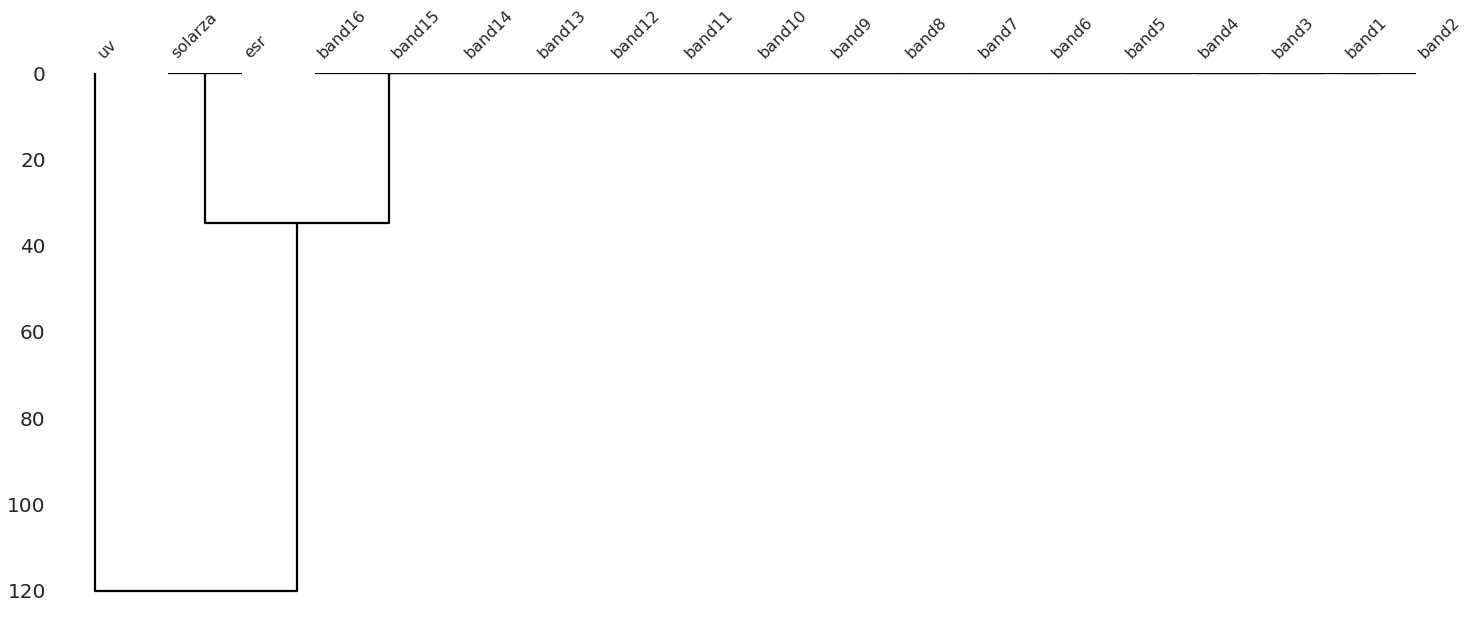

In [ ]:
autoimpute.visuals.plot_nullility_dendogram(train_108)

In [ ]:
  isna_df = []
for i in set(train_set['stn']):
  train_df = stn_split(train_set,i)
  isna_df.append(pd.DataFrame(train_df.isna().sum()))
all_isna_df = pd.concat(isna_df,axis=1)
all_isna_df.columns = set(train_set['stn'])

In [ ]:
all_isna_df

,131,132,133,165,105,138,108,13,143,112,146,115,152,156,159
uv,587,5201,1078,345,25,488,13827,3501,8904,104,14736,2141,1378,73,235
band1,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band2,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band3,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band4,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band5,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band6,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band7,1204,1204,1205,1204,1204,1207,1204,1204,1204,1204,1204,1204,1205,1204,1205
band8,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204
band9,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204,1204


### 결측치 생성

In [ ]:
train_108 = stn_split(train_set,108)
train_108 = time_feature(train_108,'Month')
train_108 = time_feature(train_108,'Day')
train_108 = time_feature(train_108,'2/Day')
train_108 = time_feature(train_108,'3/Day')
train_108 = pps(train_108,'minmax')

In [ ]:
notna_108,isna_108 = model_selection.train_test_split(train_108,
                                                      train_size=0.9 ,
                                                      shuffle=False)
notna_final_108,isna_shuffle_108 = model_selection.train_test_split(notna_108,
                                                                    test_size=0.1,
                                                                    shuffle= True,
                                                                    random_state=42)

all_na = pd.concat([isna_108,isna_shuffle_108])
all_na = all_na.sort_index()

train_108_na = train_108.copy()
nan_columns = ['uv', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7',
       'band8', 'band9', 'band10', 'band11', 'band12', 'band13', 'band14',
       'band15', 'band16']

for i in range(len(train_108_na)):
    if train_108_na.index[i] in all_na.index:
      train_108_na.loc[train_108_na.index[i],nan_columns]=np.nan     


### autoimpute - mice

In [ ]:
#!pip install autoimpute
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

In [ ]:
imp =  autoimpute.imputations.MiceImputer(
    n=20,
  #  strategy={"salary": "pmm", "gender": "bayesian binary logistic", "age": "norm"},
  #  predictors={"salary": "all", "gender": ["salary", "education", "weight"]},
  #  imp_kwgs={"pmm": {"fill_value": "random"}},
  #  visit="left-to-right",
  #  return_list=True
)

### impyute - fast_KNN

In [ ]:
#!pip install impyute
atrain_108_fast_knn = impyute.imputation.cs.fast_knn(np.array(train_108),k=4)

In [ ]:
train_108_fast_knn = pd.DataFrame(train_108_fast_knn,columns = train_108.columns, index = train_108.index)

In [ ]:
train_108_fast_knn['2020-03-01 00:00:00'	: '2020-03-01 23:50:00']

,uv,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,solarza,esr
date_time,,,,,,,,,,,,,,,,,,,
2020-03-01 00:00:00,0.990482,0.00000,-0.00057,0.00000,0.00015,-0.0003,0.00000,276.68282,233.40607,242.17228,251.38277,274.30191,250.10372,276.15670,276.46287,275.44535,262.34658,147.23785,-8.22832
2020-03-01 00:10:00,0.990482,0.00000,-0.00057,-0.00089,-0.00030,0.0006,0.00000,276.92658,233.40607,242.07041,251.30636,274.20894,250.14764,276.12601,276.54058,275.38098,262.25518,148.02612,-8.22832
2020-03-01 00:20:00,0.990482,0.00000,0.00000,0.00060,0.00045,0.0006,0.00000,276.76435,233.61643,242.20618,251.43364,274.28642,250.10372,276.11067,276.41622,275.33268,262.23689,148.66998,-8.22832
2020-03-01 00:30:00,0.990482,0.00000,-0.00057,-0.00089,0.00105,0.0000,0.00000,276.51892,233.61643,242.10440,251.22981,274.05371,250.10372,275.97243,276.27613,275.25213,262.27347,149.16019,-8.22832
2020-03-01 00:40:00,0.990482,-0.00057,0.00000,-0.00089,0.00060,0.0000,0.00000,276.27095,233.61643,241.93413,251.02502,273.91369,250.01580,275.71073,276.07344,274.97786,262.18201,149.48915,-8.22832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01 23:10:00,0.482833,-0.00057,-0.00057,-0.00030,-0.00030,0.0000,-0.00065,256.48359,241.34917,249.45967,252.90798,259.00046,242.48504,260.81595,261.01764,260.30253,252.29740,141.21452,-7.51772
2020-03-01 23:20:00,0.000000,-0.00057,-0.00057,0.00060,0.00030,0.0000,0.00000,254.33247,241.43059,248.63845,251.05067,256.30039,241.14793,258.30167,258.41382,257.54560,250.64270,142.55365,-7.51772
2020-03-01 23:30:00,0.000000,0.00000,-0.00057,-0.00060,0.00030,0.0006,0.00000,264.36984,241.83464,249.93326,253.27501,263.81403,245.16565,265.71706,264.69612,262.60697,253.61046,143.80162,-7.51772


### missingpy - missforest

In [ ]:
!pip install missingpy
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
param_grid = {
# 'num_leaves':[2,15],
#   'max_depth' : [1],
#  'min_child_samples':[1,5,10],
   'n_estimators': [200,300]
#  'learning_rate' : [0.05],
#   'bagging_fraction' : [0.5,1],
#   'feature_fraction' : [0.5,1]
#  'subsample' : [0.3,0.5,0.9],
#   'subsample_feq': [3,4,5,10]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


def search_mse(df:pd.DataFrame,df2:pd.DataFrame)->int:
  mse_result = []
  nan_columns = ['uv', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7',
       'band8', 'band9', 'band10', 'band11', 'band12', 'band13', 'band14',
       'band15', 'band16']
  for col in nan_columns:
    score= metrics.mean_squared_error(df[col],df2[col])
    mse_result.append(score)
  return np.mean(mse_result)


impute_result = {'result_param':[],'result_score':[]}
for params in all_params:
  mf_imputer = MissForest(**params,random_state=42,n_jobs=-1)
  imputer_result = mf_imputer.fit_transform(train_108_na)
  imputer_result = pd.DataFrame(imputer_result,columns = train_108_na.columns, index = train_108_na.index)
  result_notna_108,result_isna_108 = model_selection.train_test_split(imputer_result,
                                                      train_size=0.9 ,
                                                      shuffle=False)
  result_notna_final_108,result_isna_shuffle_108 = model_selection.train_test_split(result_notna_108,
                                                                    test_size=0.1,
                                                                    shuffle= True,
                                                                    random_state=42)
  result_all_na = pd.concat([result_isna_108,result_isna_shuffle_108])
  result_all_na = result_all_na.sort_index()
  result_r2 = search_mse(all_na,result_all_na)
  impute_result['result_score'].append(result_r2)
  impute_result['result_param'].append(params)  


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [ ]:
impute_result

{'result_param': [{'n_estimators': 200}, {'n_estimators': 300}],
 'result_score': [0.05596867644420523, 0.0561744069614456]}

### sklearn - lgbm

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

param_grid = {
# 'num_leaves':[2,15],
   'max_depth' : [1],
#  'min_child_samples':[1,5,10],
   'n_estimators': [223],
   'learning_rate' : [0.05],
#   'bagging_fraction' : [0.5,1],
#   'feature_fraction' : [0.5,1]
#  'subsample' : [0.3,0.5,0.9],
#   'subsample_feq': [3,4,5,10]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


def search_mse(df:pd.DataFrame,df2:pd.DataFrame)->int:
  mse_result = []
  nan_columns = ['uv', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7',
       'band8', 'band9', 'band10', 'band11', 'band12', 'band13', 'band14',
       'band15', 'band16']
  for col in nan_columns:
    score= metrics.mean_squared_error(df[col],df2[col])
    mse_result.append(score)
  return np.mean(mse_result)


impute_result = {'result_param':[],'result_score':[]}
for params in all_params:
  lgbr = lgb.LGBMRegressor(**params,random_state=42,n_jobs=-1)
  lgbr_imputer = IterativeImputer(lgbr,max_iter=20,random_state=0)
  imputer_result = lgbr_imputer.fit_transform(train_108_na)
  imputer_result = pd.DataFrame(imputer_result,columns = train_108_na.columns, index = train_108_na.index)
  result_notna_108,result_isna_108 = model_selection.train_test_split(imputer_result,
                                                      train_size=0.9 ,
                                                      shuffle=False)
  result_notna_final_108,result_isna_shuffle_108 = model_selection.train_test_split(result_notna_108,
                                                                    test_size=0.1,
                                                                    shuffle= True,
                                                                    random_state=42)
  result_all_na = pd.concat([result_isna_108,result_isna_shuffle_108])
  result_all_na = result_all_na.sort_index()
  result_r2 = search_mse(all_na,result_all_na)
  impute_result['result_score'].append(result_r2)
  impute_result['result_param'].append(params)  


In [ ]:
#lbgr 다중대치 테스트
ImputeTest_108 = stn_split(train_set,108)
lgbr_test = lgb.LGBMRegressor(n_estimators=223,
                              learing_rate=0.05,
                              max_detph=1
                              ,random_state=42,n_jobs=-1)
lgbr_imputer_test = IterativeImputer(lgbr_test,max_iter=20,random_state=0)
lgbr_imputer_test_df = lgbr_imputer_test.fit_transform(ImputeTest_108)
lgbr_imputer_test_df = pd.DataFrame(lgbr_imputer_test_df,columns = ImputeTest_108.columns,
                                    index=ImputeTest_108.index)

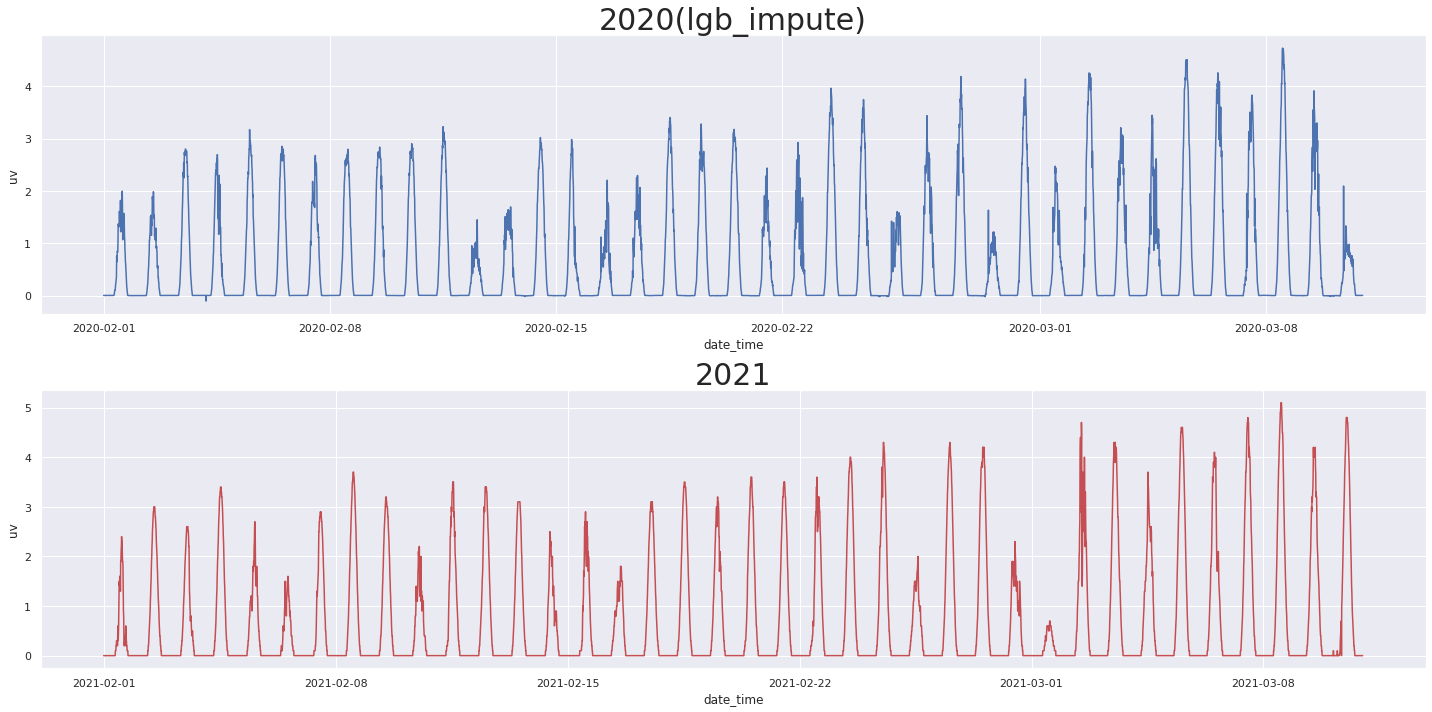

In [ ]:
%matplotlib inline 

plt.figure(figsize=(20,10))
plt.subplot(211)
sns_data = lgbr_imputer_test_df['2020-02-01':'2020-03-10']
sns.lineplot(data= sns_data, x= sns_data.index, y='uv',c='b')
plt.title('2020(lgb_impute)',fontsize=30)

plt.subplot(212)
sns_data2 = lgbr_imputer_test_df['2021-02-01':'2021-03-10']
sns.lineplot(data= sns_data2, x= sns_data2.index, y='uv',c='r')
plt.title('2021',fontsize=30)
plt.tight_layout()

### 결측치 처리 진행

In [ ]:
train_108 = stn_split(df,108)

In [ ]:
df = to_datetime(df)
df = del_999(df)

In [ ]:
lgbr = lgb.LGBMRegressor(n_estimators=223,
                         learing_rate=0.05,
                         max_detph=1,
                         random_state=42,n_jobs=-1)
lgbr_imputer = IterativeImputer(lgbr,max_iter=20,random_state=42)

In [30]:
df['year'] = np.where(df.index.year==2020,0,
                      np.where(df.index.year==2021,1,2))

In [32]:
#stn번호 넣는거 까먹지 말기
imputed_df = []
imputed_test_df = []
for stn in tqdm(set(df['stn'])):
  df_stn = stn_split(df,stn)
  df_stn = time_feature(df_stn,'Month')
  df_stn = time_feature(df_stn,'Day')
  df_stn = time_feature(df_stn,'2/Day')
  df_stn = time_feature(df_stn,'3/Day')
  train,test = train_test_split(df_stn)
  scaled_train,scaled_test = pps(train,test,'minmax')
  imputed_stn = lgbr_imputer.fit_transform(scaled_train)
  imputed_stn_test = lgbr_imputer.transform(scaled_test)
  imputed_stn = pd.DataFrame(imputed_stn, columns = scaled_train.columns, index=scaled_train.index)
  imputed_stn_test = pd.DataFrame(imputed_stn_test, columns = scaled_test.columns, index=scaled_test.index)
  imputed_stn['stn'] = stn
  imputed_stn_test['stn'] = stn
  imputed_df.append(imputed_stn)
  imputed_test_df.append(imputed_stn_test)

all_df = pd.concat(imputed_df)
all_test_df = pd.concat(imputed_test_df)
all_df.to_pickle('./lgb_train.pkl')
all_test_df.to_pickle('./lgb_test.pkl')

 27%|██▋       | 4/15 [1:36:27<4:25:16, 1446.93s/it]


KeyboardInterrupt: ignored

In [ ]:
#stn번호 넣는거 까먹지 말기
imputed_df = []
for stn in tqdm(set(train_set['stn'])):
  train_stn = stn_split(train_set,stn)
  train_stn = time_feature(train_stn,'Month')
  train_stn = time_feature(train_stn,'Day')
  train_stn = time_feature(train_stn,'3/Day')
  train_stn = pps(train_stn,'minmax')
  imputed_stn = lgbr_imputer.fit_transform(train_stn)
  imputed_stn = pd.DataFrame(imputed_stn, columns = train_stn.columns, index=train_stn.index)
  imputed_stn['stn'] = stn
  imputed_df.append(imputed_stn)

100%|██████████| 15/15 [4:21:09<00:00, 1044.65s/it]


In [ ]:
all_df = pd.concat(imputed_df)

In [ ]:
with open("/content/drive/MyDrive/날씨/lgb_df.pkl","rb") as fr:
    data = pickle.load(fr)

In [ ]:
data

,uv,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,esr,Month sin,Month cos,Day sin,Day cos,2/Day sin,2/Day cos,3/Day sin,3/Day cos,stn
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.009771,0.009774,0.011324,0.010648,0.019778,0.018657,0.536633,0.680527,0.747787,...,0.004154,0.487099,0.999834,0.500000,1.000000,0.500000,1.000000,0.500000,1.000000,131
2020-01-01 00:10:00,0.0,0.009279,0.009774,0.010194,0.011053,0.018288,0.017717,0.534080,0.677492,0.745142,...,0.004154,0.487816,0.999852,0.521810,0.999524,0.543578,0.998097,0.565263,0.995722,131
2020-01-01 00:20:00,0.0,0.009279,0.009286,0.011324,0.010378,0.019778,0.018657,0.535360,0.675969,0.743373,...,0.004154,0.488532,0.999868,0.543578,0.998097,0.586824,0.992404,0.629410,0.982963,131
2020-01-01 00:30:00,0.0,0.009279,0.009286,0.012740,0.010243,0.020269,0.018657,0.513766,0.679011,0.743816,...,0.004154,0.489249,0.999884,0.565263,0.995722,0.629410,0.982963,0.691342,0.961940,131
2020-01-01 00:40:00,0.0,0.008796,0.009286,0.011324,0.010648,0.019287,0.017717,0.509430,0.679011,0.744700,...,0.004154,0.489966,0.999899,0.586824,0.992404,0.671010,0.969846,0.750000,0.933013,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:10:00,0.0,0.009279,0.010963,0.011709,0.011562,0.020565,0.017734,0.725256,0.573162,0.628261,...,0.029698,0.536638,0.998656,0.391780,0.988148,0.288691,0.953154,0.195619,0.896677,159
2021-12-31 23:20:00,0.0,0.009771,0.010416,0.012314,0.009630,0.021640,0.018675,0.723271,0.567629,0.616301,...,0.029698,0.537353,0.998603,0.413176,0.992404,0.328990,0.969846,0.250000,0.933013,159
2021-12-31 23:30:00,0.0,0.009771,0.010963,0.011709,0.009906,0.021103,0.018675,0.721257,0.569480,0.617876,...,0.029698,0.538067,0.998549,0.434737,0.995722,0.370590,0.982963,0.308658,0.961940,159


정상성 테스트 싹다해보기, 로그변환, 비정상 데이터들 추출해보기, x 변수 추출하기